In [2]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import awkward
import coffea.processor as processor


import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import json
datasets_=json.load(open('../Samples/signal_4mu_200130.json'))

datasets=dict()
for key in datasets_:
    datasets[key]={'files': datasets_[key], 'treename': 'ffNtuplizer/ffNtuple'}
    print(key)


mXX-1000_mA-0p25_lxy-300
mXX-1000_mA-1p2_lxy-300
mXX-1000_mA-5_lxy-300
mXX-100_mA-0p25_lxy-300
mXX-100_mA-1p2_lxy-300
mXX-100_mA-5_lxy-300
mXX-150_mA-0p25_lxy-300
mXX-150_mA-1p2_lxy-300
mXX-150_mA-5_lxy-300
mXX-200_mA-0p25_lxy-300
mXX-200_mA-1p2_lxy-300
mXX-200_mA-5_lxy-300
mXX-500_mA-0p25_lxy-300
mXX-500_mA-1p2_lxy-300
mXX-500_mA-5_lxy-300
mXX-800_mA-0p25_lxy-300
mXX-800_mA-1p2_lxy-300
mXX-800_mA-5_lxy-300
mXX-1000_mA-0p25_lxy-0p3
mXX-100_mA-5_lxy-0p3


In [4]:
#Goal = 3893
select_signals = {'mXX-500_mA-1p2_lxy-300'} #'mXX-100_mA-5_lxy-0p3'} #,'mXX-100_mA-5_lxy-300'}
select_datasets=dict()
for sig in select_signals:
    select_datasets[sig]=datasets[sig] 

In [41]:
class ProcessorPlots(processor.ProcessorABC):
    def __init__(self):
        
        pt_binning = np.concatenate([np.arange(0  , 100, 20),
                             np.arange(100, 200, 40),
                             np.arange(200, 400, 70),
                             np.arange(400, 800, 100)])

        dataset_axis = hist.Cat('dataset', '')
        pt_axis = hist.Bin("pt", "lepton jet pt", pt_binning)
        mu_axis = hist.Bin("num_mu", "number of muons in a lepton jet", 10,0,10)

        self.triggers = [
            "HLT_DoubleL2Mu23NoVtx_2Cha",
            "HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched",
            "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed",
            "HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched",
            "HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4",
            "HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4",
        ]
        
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("pt", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
        
    def minDSADistance(self, lj_dsas, distances):
        dRs = distances[lj_dsas.flatten(axis=1)].flatten()
        dRsPerLJ = awkward.JaggedArray.fromcounts(lj_dsas.flatten(axis=0).counts, dRs)
        dRsPerLJPerEvent = awkward.JaggedArray.fromcounts(lj_dsas.counts, dRsPerLJ)
    
        return dRsPerLJPerEvent.min()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        ##############
        #Define jagged candidate arrays for lepton jets and dsa muons
        ##############
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            minDCA=df["pfjet_pfcands_minTwoTkDist"],
            minD0=df["pfjet_pfcand_tkD0Min"],
            muonsPerJet=df["pfjet_muon_n"],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        ) 
        
        dsaMuons = JaggedCandidateArray.candidatesfromcounts(
            df['dsamuon_p4'],
            deltaRCosmicDSA=df["dsamuon_deltaRCosmicDSA"],
            deltaRCosmicSeg=df["dsamuon_deltaRCosmicSeg"],
            px=df['dsamuon_p4.fCoordinates.fX'],
            py=df['dsamuon_p4.fCoordinates.fY'],
            pz=df['dsamuon_p4.fCoordinates.fZ'],
            energy=df['dsamuon_p4.fCoordinates.fT'],
        ) 
        
        ##############
        # Lepton jet cuts
        ##############
        leptonjet_pt_eta = (leptonjets.pt > 30) & (abs(leptonjets.eta)<2.4)
        muon_type=(leptonjets.muonsPerJet > 0) 
    
        #Calculate sum of charges of muons in the lepton jet
        #Type 3 = pfmuon, Type 8 = dsamuon
        #This cut only needs to be applied to muon-type lepton-jets
        #pfjet_pfcand_charge has three layers--pfcandidates per lepton jet per event--so we need to construct it differently
        cands_charge = awkward.fromiter(df['pfjet_pfcand_charge'])
        cands_type = awkward.fromiter(df['pfjet_pfcand_type'])
        LJcharge = cands_charge[(cands_type==3) | (cands_type ==8)].sum()
        neutral = (LJcharge == 0)
        
        #Calculate minimum distance between dsa muons and dsa muons and muon segments (part of the cosmic veto)
        dsaIds = awkward.fromiter(df['pfjet_pfcand_dsamuonIdx'])
        minDRCosmicDSA = self.minDSADistance(dsaIds, dsaMuons.deltaRCosmicDSA)
        minDRCosmicSeg = self.minDSADistance(dsaIds, dsaMuons.deltaRCosmicSeg)
        
        minTrkTrkDCA = (leptonjets.minDCA < 20)
        
        cands_dz = abs(awkward.fromiter(df['pfjet_pfcand_tkDz']))
        maxDz = (cands_dz.max() < 40)
      
        ##############
        #Cut flow for lepton jets
        ##############
        output['cutflow']['totalLJs']=leptonjets.counts.sum()
        output['cutflow']['pt_eta']=leptonjets[leptonjet_pt_eta].counts.sum()
        output['cutflow']['LJs_muon']=leptonjets[leptonjet_pt_eta & muon_type].counts.sum()
        output['cutflow']['LJs_neutral']=leptonjets[leptonjet_pt_eta & muon_type
                                                    & neutral].counts.sum()
        output['cutflow']['LJs_minDSA']=leptonjets[leptonjet_pt_eta & muon_type 
                                                   & neutral & (minDRCosmicDSA > 0.05)].counts.sum()
        output['cutflow']['LJs_minSeg']=leptonjets[leptonjet_pt_eta & muon_type 
                                                   & neutral & (minDRCosmicDSA > 0.05) & (minDRCosmicSeg > 0.05)].counts.sum()
        output['cutflow']['LJs_minDCA']=leptonjets[leptonjet_pt_eta & muon_type 
                                                   & neutral & (minDRCosmicDSA > 0.05) & (minDRCosmicSeg > 0.05)
                                                   & minTrkTrkDCA].counts.sum()
        output['cutflow']['LJs_maxDz']=leptonjets[leptonjet_pt_eta & muon_type 
                                                   & neutral & (minDRCosmicDSA > 0.05) & (minDRCosmicSeg > 0.05)
                                                   & minTrkTrkDCA & maxDz].counts.sum()
        output['cutflow']['LJs_minD0']=leptonjets[leptonjet_pt_eta & muon_type 
                                                   & neutral & (minDRCosmicDSA > 0.05) & (minDRCosmicSeg > 0.05)
                                                   & minTrkTrkDCA & maxDz & (leptonjets.minD0 > 0.01)].counts.sum()
        ##############
        # Event-level cuts 
        ##############
        isMuonNeutralDZ = (muon_type & neutral & maxDz) | (~muon_type)
        baseLeptonJetID = leptonjet_pt_eta & minTrkTrkDCA & isMuonNeutralDZ
        
        LJs = leptonjets[baseLeptonJetID]
        twoljs = LJs.counts >=2
        
        muonLeptonJetID = leptonjet_pt_eta & muon_type & neutral & (minDRCosmicDSA > 0.05) & (minDRCosmicSeg > 0.05) & minTrkTrkDCA & maxDz  
        
        oneLJpassingD0 = leptonjets[muonLeptonJetID & (leptonjets.minD0 > 0.01)].counts >=1
        
        vertex_filter = df['metfilters_PrimaryVertexFilter'] > 0
        
        pass_trig_dict = dict()
        for trig in self.triggers:
            pass_trig_dict[trig] = df[trig]    
        pass_trig = np.logical_or.reduce([pass_trig_dict[t] for t in self.triggers])
        
        cosmicveto_pairs = (df['cosmicveto_parallelpairs'] < 8)

        ##############
        # Event-level cutflow (weird order to match numbers Weinan gave me from his ROOT code)
        ##############
        #Note that there is no particular reason to use the 'cosmicveto_result' array. 
        #I just needed an array that wasn't jagged and had one entry per event
        #The important thing is how many events survive each mask (mask is applied using [] and the number is calculated with .size)
        output['cutflow']['totalevents']=df['cosmicveto_result'].size
        output['cutflow']['trig']=df['cosmicveto_result'][pass_trig].size
        output['cutflow']['2LJ']=df['cosmicveto_result'][twoljs & pass_trig].size
        output['cutflow']['PV']=df['cosmicveto_result'][twoljs & pass_trig & vertex_filter].size
        output['cutflow']['cosmicveto']=df['cosmicveto_result'][twoljs & pass_trig & vertex_filter
                                                                & cosmicveto_pairs].size
        output['cutflow']['4mu']=df['cosmicveto_result'][(leptonjets[baseLeptonJetID & muon_type & neutral].counts>=2)
                                                                & vertex_filter & pass_trig & cosmicveto_pairs].size
        output['cutflow']['ljcosmicveto']=df['cosmicveto_result'][(leptonjets[muonLeptonJetID].counts>=2)
                                                                & vertex_filter & pass_trig & cosmicveto_pairs].size
        output['cutflow']['mind0']=df['cosmicveto_result'][(leptonjets[muonLeptonJetID].counts>=2) & oneLJpassingD0
                                                                & vertex_filter & pass_trig & cosmicveto_pairs].size

        output['pt'].fill(dataset=dataset, pt=leptonjets.pt.flatten())
        
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [42]:
output = processor.run_uproot_job(select_datasets,
                                  treename=None,
                                  processor_instance=ProcessorPlots(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=1, flatten=True),
                                  chunksize=5000,
                                  #maxchunks=1 #Commented out = process all events. Uncommented = easier debugging
                                 )
[print(key,output['cutflow'][key]) for key in output['cutflow']]


totalLJs 9748
pt_eta 9642
LJs_muon 9460
LJs_neutral 9035
LJs_minDSA 9004
LJs_minSeg 8862
LJs_minDCA 8672
LJs_maxDz 8622
LJs_minD0 7081
totalevents 8769
trig 7597
2LJ 771
PV 771
cosmicveto 768
4mu 728
ljcosmicveto 706
mind0 689


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [39]:
print(output['pt'].integrate('dataset').values())

{(): array([   0.,  205.,  236.,  254.,  392., 1234., 1708., 1037., 3586.,
        732.,  182.,   97.,   49.,   21.])}


/uscms/home/ahall/nobackup/LPC-DM/SIDM/anaconda3/envs/FireHydrant/lib/python3.8/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


(0.1, 30000)

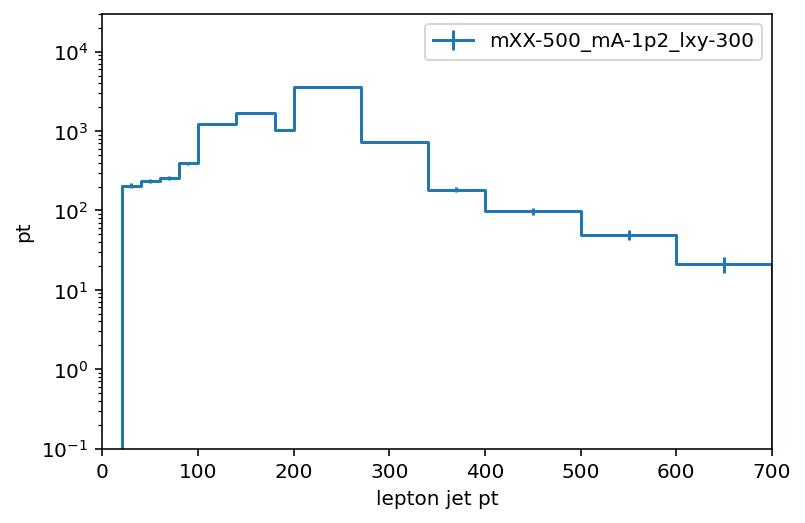

In [40]:
ax = hist.plot1d(output['pt'], overlay='dataset')
ax.set_yscale('log')
ax.set_ylim(0.1, 30000)

In [ ]:
hist.plot1d?